**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

###  Data Preparation 

Your function returned a count of 26376  cars and 26904  non-cars
of size:  (64, 64, 3)  and data type: float32


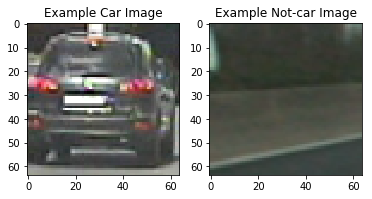

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# images are divided up into vehicles and non-vehicles

images = glob.glob('dataset/**/**/*.png', recursive=True)
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Feature Extraction

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    """Calculated spatial features
    Args:
        img (numpy.array): image
        size (tuple): resize img before calculating features
            default value is (32, 32)
    Returns:
        feature_vector(numpy.array)
    """
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """Calculate histograms of all channels of the image,
    concatenate and return it as feature vector
    Args:
        img (numpy.array): image
        nbins (int): number of histogram bins, 32 by default
        bins_range (tuple): range for bins values, default (0, 1)
    Returns:
        feature_vector(numpy.array)
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Return HOG features and its visualization if needed
    Args:
        img (numpy.array): image for feature extraction
        orient (int): number of orientations
        pix_per_cell (int): number of pixels in HOG cell
        cell_per_block (int): number of HOG cells in block
        vis (boolean): default False, return visualization image as second return parameter
        feature_vec (boolean): default True, return features as vector
    Returns:
        features or features, hog_image(image)
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Let's visualize HOG features on a random car and non-car image

/Users/ram/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


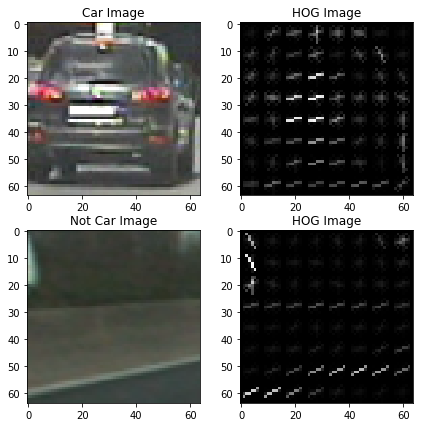

Hog Feature (Car) size:  1764
Hog Feature (Not Car) size:  1764


In [3]:
car_features, car_hog = get_hog_features(car_image[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
notcar_features, notcar_hog = get_hog_features(notcar_image[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Plot original and hog images
fig = plt.figure(figsize=(7,7))
plt.subplot(221)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(222)
plt.imshow(car_hog, cmap='gray')
plt.title('HOG Image')
plt.subplot(223)
plt.imshow(notcar_image)
plt.title('Not Car Image')
plt.subplot(224)
plt.imshow(notcar_hog, cmap='gray')
plt.title('HOG Image')
plt.show()

print("Hog Feature (Car) size: ", len(car_features))
print("Hog Feature (Not Car) size: ", len(notcar_features))

### Extract and Combine features

In [33]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append the new feature vector to the features list
        file_features.append(spatial_features)

        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)

t=time.time()
car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=spatial_size,
                                   hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

232.76 Seconds to extract HOG features...


### Normalize features

In [34]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

### Training

In [35]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
81.52 Seconds to train SVC...


### Testing

In [36]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9997
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  1.  1.  0.  1.]
0.00723 Seconds to predict 10 labels with SVC


### Find Cars in Image

In [37]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hog_channel, hist_bins, draw, ignore_prediction=False):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            # ignore_prediction flag helps us explore multi-scale windows.
            if test_prediction == 1 and ignore_prediction == False:
                box_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                if draw == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            if ignore_prediction == True:
                box_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                if draw == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    # Demonstrate search window size
    if ignore_prediction == True:
        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    return draw_img, box_list

###  Vehicle detection on test image

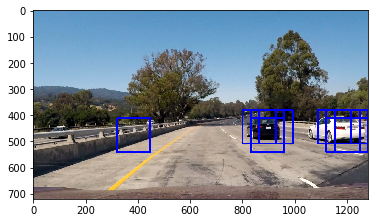

In [38]:
img = mpimg.imread('test_images/test1.jpg')

ystart = 380
ystop = 600
scale = 2
    
out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hog_channel, hist_bins, draw=True)

plt.imshow(out_img)
plt.show()

### Multiple Detections & False Positives
Let's use various window sizes and build heat-maps to combine overlapping detections while eliminating false positives.

2 cars found


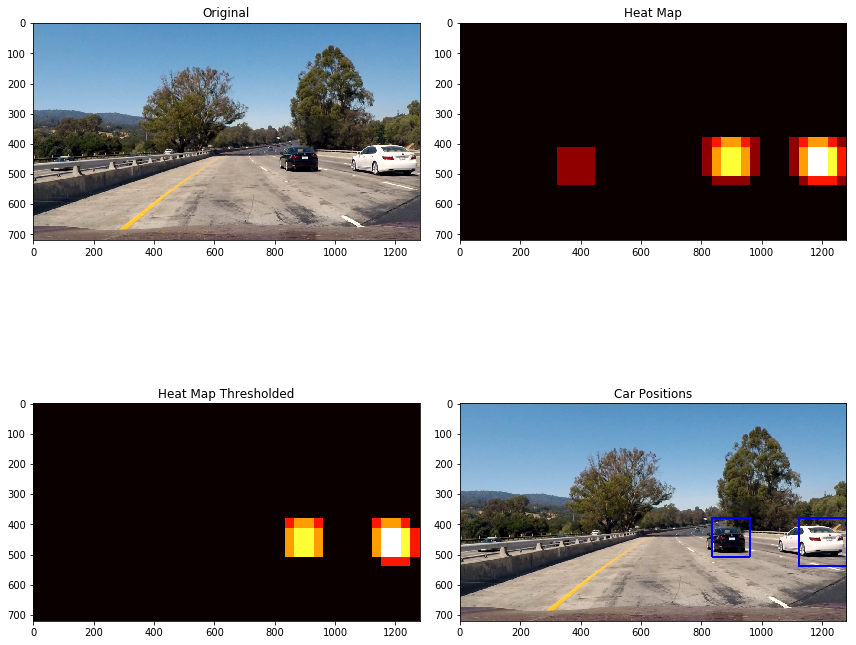

In [43]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_bboxes(img, box_list, threshold):
    # Create empty heat image
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    heat_copy = np.copy(heat)
    # Apply threshold to help remove false positives
    heat_thres = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmap_thres = np.clip(heat_thres, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap_thres)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat_copy, heatmap_thres, labels
    

def find_cars_with_heatmap(img, ystart, ystop, scale, threshold=1):
    _, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell,
                            cell_per_block, spatial_size, hog_channel, hist_bins, draw=False)
    return find_bboxes(img, box_list, threshold)

def draw_find_cars(draw_img, heatmap, heatmap_thres, labels):
    print(labels[1], 'cars found')
    fig = plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Original')
    plt.subplot(222)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(223)
    plt.imshow(heatmap_thres, cmap='hot')
    plt.title('Heat Map Thresholded')
    plt.subplot(224)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()
    plt.show()

draw_img, heatmap, heatmap_thres, labels = find_cars_with_heatmap(img, ystart, ystop, scale, 1)
draw_find_cars(draw_img, heatmap, heatmap_thres, labels)

### Multi-Scale Windows

Vehicles closer to the camera look bigger in size compared to the ones which are far. So, it makes sense to use different window sizes and regions to find cars.

In [44]:
# windows is an array of (y_start, y_end, scale) tuple.
def multi_scale_find_cars(img, windows, threshold=1):
    box_list = []
    # Loop through various window regions to find all bounding boxes of car.
    for (ystart, ystop, scale) in windows:
        _, box_list_current = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell,
                                        cell_per_block, spatial_size, hog_channel, hist_bins, draw=False)
        box_list = box_list + box_list_current
    # Apply heat map method and find single best region for every car detected.
    return find_bboxes(img, box_list, threshold)

Let's explore various windows here!

Number of boxes:  308


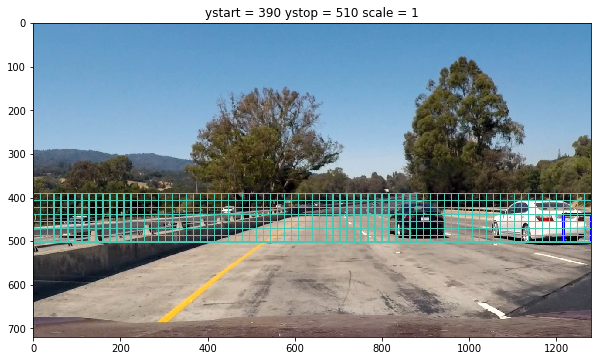

In [63]:
def draw_boxes(img, box_list, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in box_list:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_windows(img, ystart, ystop, scale):
    draw_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell,
                                   cell_per_block, spatial_size, hog_channel, hist_bins, draw=False, ignore_prediction=True)
    print('Number of boxes: ', len(box_list))
    color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    draw_img = draw_boxes(draw_img, box_list, color, thick=2)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.title("ystart = "+ str(ystart) + " ystop = " + str(ystop) + " scale = " + str(scale))
    plt.show()

ystart = 390
ystop = 510
scale = 1
draw_windows(img, ystart, ystop, scale)

Number of boxes:  250


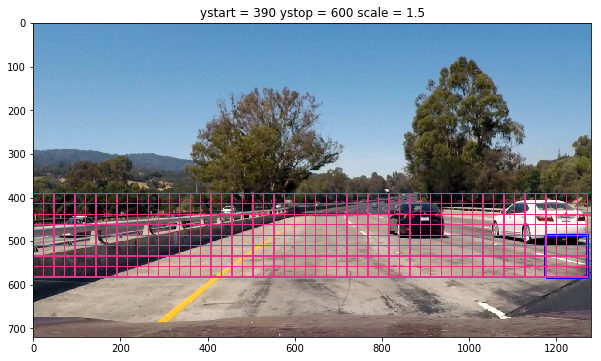

In [71]:
ystart = 390
ystop = 600
scale = 1.5
draw_windows(img, ystart, ystop, scale)

Number of boxes:  148


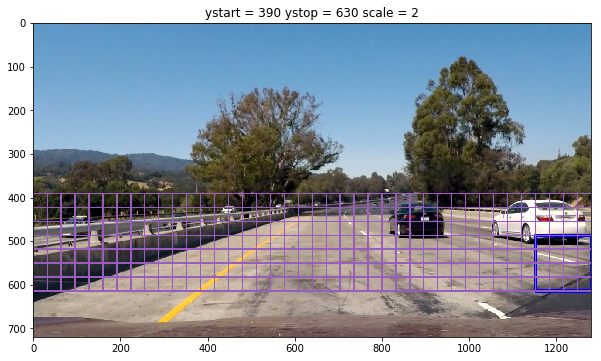

In [69]:
ystart = 390
ystop = 630
scale = 2
draw_windows(img, ystart, ystop, scale)

Number of boxes:  116


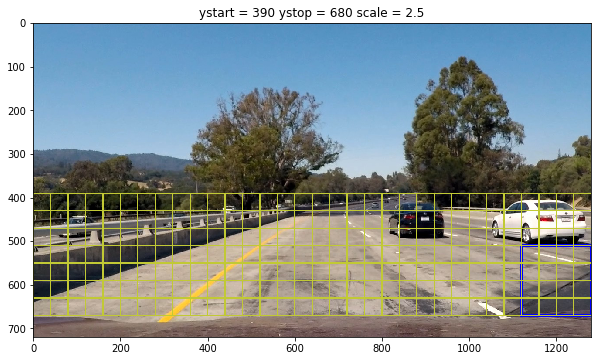

In [72]:
ystart = 390
ystop = 680
scale = 2.5
draw_windows(img, ystart, ystop, scale)

Let's combine all window searches!

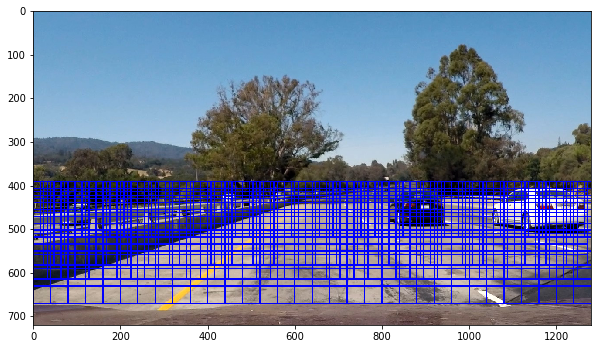

In [74]:
def visualize_multi_scale_windows(img, windows):
    box_list = []
    # Loop through various window regions to find all bounding boxes of car.
    for (ystart, ystop, scale) in windows:
        _, box_list_current = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell,
                                        cell_per_block, spatial_size, hog_channel, hist_bins, draw=False, ignore_prediction=True)
        box_list = box_list + box_list_current
    color = (0, 0, 255) #blue
    draw_img = draw_boxes(img, box_list, color, thick=2)
    plt.figure(figsize=(10,10))
    plt.imshow(draw_img)
    plt.show()

windows = [(390, 520, 1.0), (390, 600, 1.5), (390, 620, 2), (390, 680, 2.5)]
visualize_multi_scale_windows(img, windows)

Let's find cars with multi scale window search method!

2 cars found


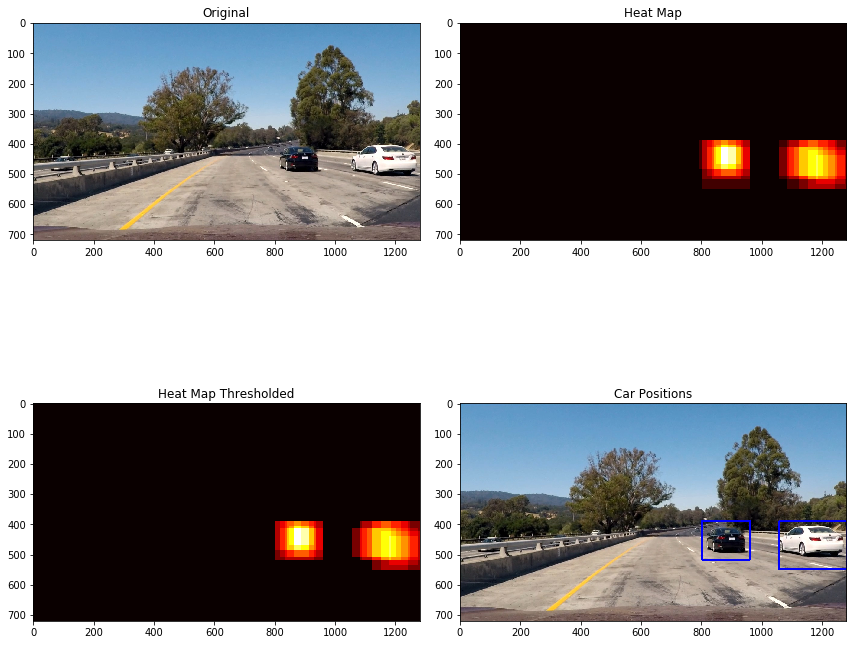

In [75]:
draw_img, heatmap, heatmap_thres, labels = multi_scale_find_cars(img, windows, threshold=1)
draw_find_cars(draw_img, heatmap, heatmap_thres, labels)

Let's find cars in all test images!

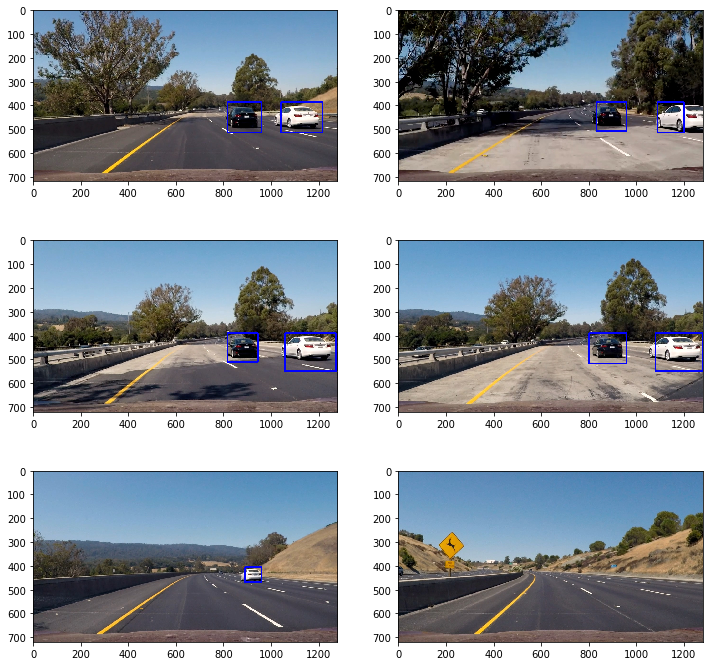

In [76]:
def find_cars_opt(img):
    draw_img, _, _, _ = multi_scale_find_cars(img, windows, threshold=2)
    return draw_img

images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(12,12))
axes = axs.ravel()

for i, image in enumerate(images):
    axes[i].imshow(find_cars_opt(mpimg.imread(image)))
plt.show()

## Video

Let's run the vehicle detection algorithm on test and project videos.

In [77]:
from collections import deque

# Heat images for last 7 frames
heat_images = deque(maxlen=7)
threshold = 7

def find_cars_opt_video(img):
    box_list = []
    # Loop through various window regions to find all bounding boxes of car.
    for (ystart, ystop, scale) in windows:
        _, box_list_current = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell,
                                        cell_per_block, spatial_size, hog_channel, hist_bins, draw=False)
        box_list = box_list + box_list_current
    # Apply heat map method and find single best region for every car detected.
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    heat_images.append(heat)
    heat = np.sum(np.array(heat_images), axis=0)
    # Apply threshold to help remove false positives
    heat_thres = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap_thres = np.clip(heat_thres, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap_thres)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [78]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_file = 'test_output.mp4'
test_video = VideoFileClip('test_video.mp4')
test_video_out = test_video.fl_image(find_cars_opt_video)
%time test_video_out.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:39<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 38.5 s, sys: 1.66 s, total: 40.1 s
Wall time: 40.4 s


In [79]:
# Heat images for last 7 frames
heat_images = deque(maxlen=7)
output_file = 'project_output.mp4'
test_video = VideoFileClip('project_video.mp4')
test_video_out = test_video.fl_image(find_cars_opt_video)
%time test_video_out.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [21:54<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 21min 13s, sys: 56 s, total: 22min 9s
Wall time: 21min 55s
